# BIKESHARE EDA & PREPROCESSING

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
- datetime - hourly date + timestamp  
- season 
    - 1 = spring, 
    - 2 = summer, 
    - 3 = fall, 
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals <- PREDICTION

## Notebook Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
from src import DataLoader

## Extracting the Train and Test Data

In [3]:
loader = DataLoader()

train_df, test_df = loader.get_train_test_data()


        Data Loader initialized with data path: ../data/
            - Use load_raw() to load raw data
            - Use get_train_test_data() to get raw train and test data  
            - Use save_feature_engineered_data() to save feature engineered data
            - Use load_feature_engineered() to load feature engineered data
              
            - Use set_as_category() to set columns as category

        Checkpoints available: ['hyperparameter_tuning']
        


/Users/samuel/Programing/bike_sharing_demand/notebooks/../src/data_loader.py:54: UserWarning: load_raw() method called to load raw data automatically. Use load_feature_engineered() to load feature engineered data checkpoint.
  warnings.warn(msg)


In [4]:
# Dropping casual and registered columns since these are related to the target variable
train_df.drop(['casual', 'registered'], axis=1, inplace=True)

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


## Inspecting Null Values

No null values found.

In [5]:
test_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## Inspecting Distribution and Correlation

We can see that the big drivers for the count of bike rentals are the temperature and the humidity. The temperature and the "feels like" temperature are highly correlated, so we can drop one of them. And since the atemp is less correlated with count, it will be the one to be dropped. The windspeed and the humidity are also correlated, but not as much as the temperature and the "feels like" temperature.

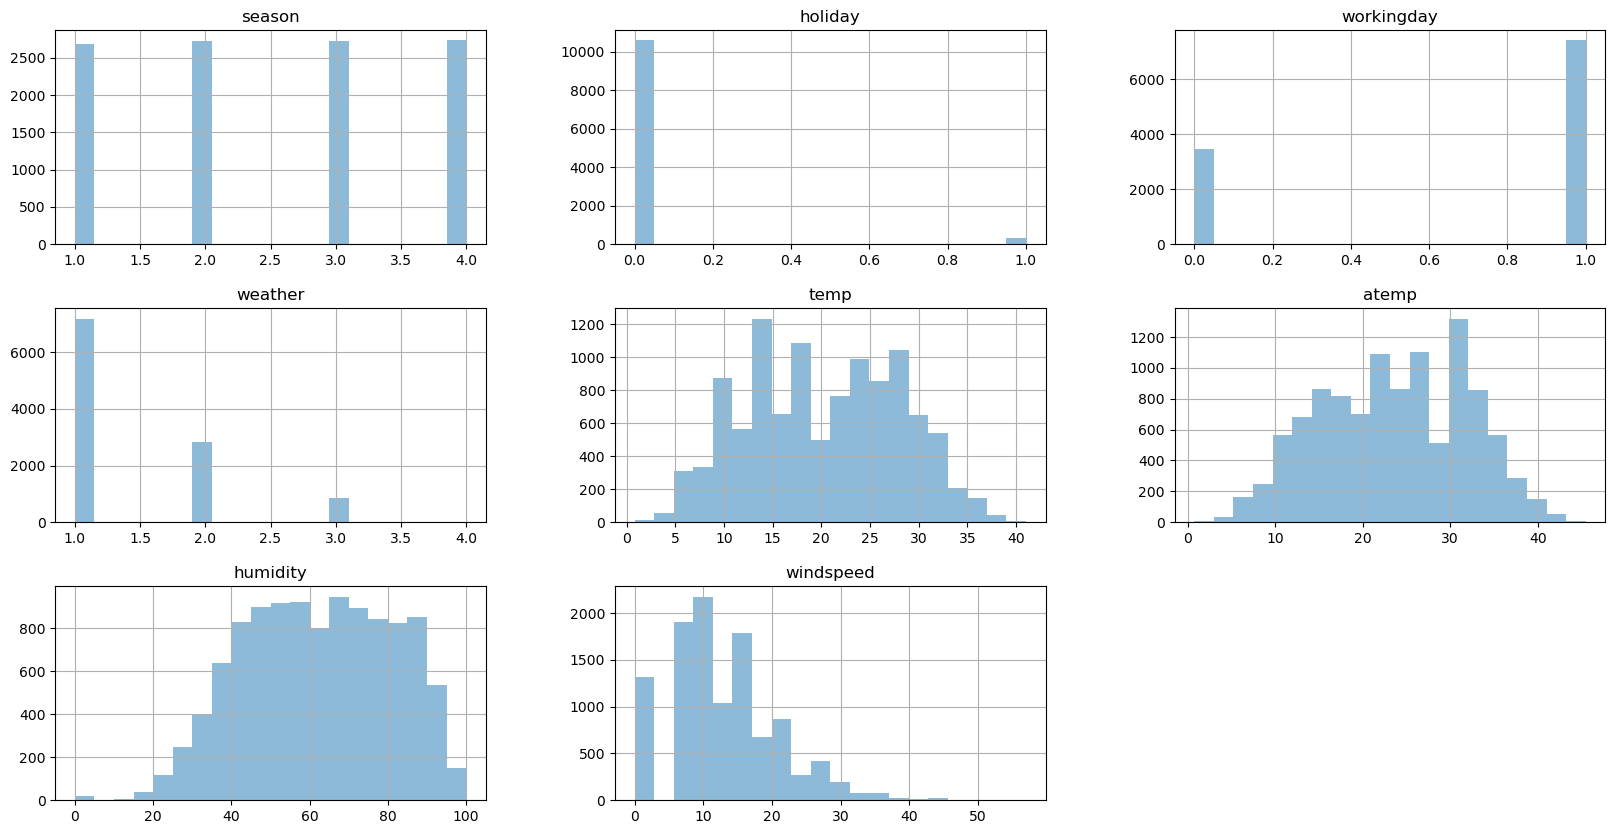

In [6]:
_ = train_df.drop(columns=["count"]).hist(figsize=(20, 10), bins=20, alpha=0.5)

In [7]:
# Create heatmap of correlations
correlation_df = train_df.drop(columns=["datetime"]).corr()
correlation_df.style.background_gradient(cmap='coolwarm')

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


In [8]:
# Identify correlation higher than 0.9
correlation_threshold = 0.9
correlation_matrix = correlation_df.abs() > correlation_threshold

# Find pairs of features with high correlation
correlation_matrix = correlation_matrix.stack()
correlation_matrix = correlation_matrix[correlation_matrix]
correlation_matrix = correlation_matrix.reset_index()
correlation_matrix.columns = ["Feature 1", "Feature 2", "Correlation"]

# Where Feature 1 is not equal to Feature 2
correlation_matrix = correlation_matrix[correlation_matrix["Feature 1"] != correlation_matrix["Feature 2"]]
display(correlation_matrix)

# Identify which feature correlates more with count
correlation_with_count = correlation_df["count"].abs().sort_values(ascending=False)
correlation_with_count.to_frame().style.background_gradient(cmap='hot')

,Feature 1,Feature 2,Correlation
5,temp,atemp,True
6,atemp,temp,True


,count
count,1.000000
temp,0.394454
atemp,0.389784
humidity,0.317371
season,0.163439
weather,0.128655
windspeed,0.101369
workingday,0.011594
holiday,0.005393


In [9]:
# Dropping atemp since it is highly correlated with temp
train_df.drop(columns=["atemp"], inplace=True)
test_df.drop(columns=["atemp"], inplace=True)

## Inspecting Category Types

Weather and Season are categorical variables. These need to be converted to dummy variables, or set as type category. We are setting them to category type.

In [10]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1


In [11]:
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
humidity        int64
windspeed     float64
count           int64
dtype: object

In [12]:
# Testing the function to use on the bikeshare notebook
train_df, test_df = loader.set_as_category(columns=["season", "weather"])

In [13]:
train_df.dtypes

datetime        object
season        category
holiday          int64
workingday       int64
weather       category
temp           float64
humidity         int64
windspeed      float64
count            int64
dtype: object

## Separating the datetime column into year, month, day, hour and weekday

In [14]:
train_df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0000,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0000,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0000,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0000,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0000,1
...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,50,26.0027,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,57,15.0013,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,61,15.0013,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,61,6.0032,129


In [15]:
# Create day of of the week feature
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
train_df["day_of_week"] = train_df["datetime"].dt.dayofweek.astype("category")

test_df["datetime"] = pd.to_datetime(test_df["datetime"])
test_df["day_of_week"] = test_df["datetime"].dt.dayofweek.astype("category")

test_df["datetime"] = pd.to_datetime(test_df["datetime"])
test_df["day_of_week"] = test_df["datetime"].dt.dayofweek.astype("category")


# Sparating hour and minute from datetime
train_df["hour"] = train_df["datetime"].dt.hour
train_df["minute"] = train_df["datetime"].dt.minute
train_df["date"] = train_df["datetime"].dt.date

test_df["hour"] = test_df["datetime"].dt.hour
test_df["minute"] = test_df["datetime"].dt.minute
test_df["date"] = test_df["datetime"].dt.date

test_df["hour"] = test_df["datetime"].dt.hour
test_df["minute"] = test_df["datetime"].dt.minute
test_df["date"] = test_df["datetime"].dt.date

# Dropping datetime column
train_df.drop(columns=["datetime"], inplace=True)
test_df.drop(columns=["datetime"], inplace=True)

train_df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,day_of_week,hour,minute,date
0,1,0,0,1,9.84,81,0.0,16,5,0,0,2011-01-01
1,1,0,0,1,9.02,80,0.0,40,5,1,0,2011-01-01
2,1,0,0,1,9.02,80,0.0,32,5,2,0,2011-01-01
3,1,0,0,1,9.84,75,0.0,13,5,3,0,2011-01-01
4,1,0,0,1,9.84,75,0.0,1,5,4,0,2011-01-01


## Saving checkpoint for hyperparameter tuning

In [17]:
loader.save_feature_engineered_data(train_df, test_df, checkpoint_name="hyperparameter_tuning")

Feature engineered data saved successfully!
